# 05_event_dataset.ipynb

### Creates a Pandas DataFrame of extreme event attributes and saves a CSV file for each labeled event.


In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.measure import regionprops 
# from dask_image.ndmeasure import label as label_dask
from skimage.measure import label as label_np
from datetime import date
from tqdm import tqdm

import dask
dask.config.set({"array.slicing.split_large_chunks": False});

#### Import Ocetrac labels and SST data


In [65]:
file_path_list = ('/burg/abernathey/users/hillary/oisst_v21/ocetrac_notrend.nc',
                  '/burg/abernathey/users/hillary/oisst_v21/positive_extremes_OISSTv21.nc')

ds = xr.open_mfdataset(file_path_list)
ssta = ds.mhw_ssta_notrend
labels = ds.ocetrac_labels
num_events = labels.attrs['final objects tracked']
print(f"There are {num_events} total events tracked.")

ds

There are 770 total events tracked.


<xarray.Dataset>
Dimensions:                     (time: 478, lat: 720, lon: 1440, month: 12)
Coordinates:
  * month                       (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * time                        (time) datetime64[ns] 1981-09-01 ... 2021-06-01
  * lat                         (lat) float32 -89.88 -89.62 ... 89.62 89.88
  * lon                         (lon) float32 0.125 0.375 0.625 ... 359.6 359.9
Data variables:
    ssta_stn_notrend            (time, lat, lon) float64 dask.array<chunksize=(478, 720, 1440), meta=np.ndarray>
    prct_notrend                (month, lat, lon) float64 dask.array<chunksize=(12, 720, 1440), meta=np.ndarray>
    mhw_ssta_notrend            (time, lat, lon) float64 dask.array<chunksize=(478, 720, 1440), meta=np.ndarray>
    mhw_ssta_notrend_noNino3    (time, lat, lon) float64 dask.array<chunksize=(478, 720, 1440), meta=np.ndarray>
    mhw_ssta_notrend_noNino3_4  (time, lat, lon) float64 dask.array<chunksize=(478, 720, 1440), meta=np.ndarray>
    mhw_ssta_notrend_noNino4    (time, lat, lon) float64 dask.array<chunksize=(478, 720, 1440), meta=np.ndarray>
    ocetrac_labels              (time, lat, lon) float64 dask.array<chunksize=(478, 720, 1440), meta=np.ndarray>
Attributes:
    description:  standardized SST anomalies above positive extreme threshold
    threshold:    0.9
    data:         preprocessed monthly averaged OISST v2.1

In [66]:
%%time
labels.load();

CPU times: user 0 ns, sys: 1.09 s, total: 1.09 s
Wall time: 1.1 s


<xarray.DataArray 'ocetrac_labels' (time: 478, lat: 720, lon: 1440)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * time     (time) datetime64[ns] 1981-09-01 1981-10-01 ... 2021-06-01
  * lat      (lat) float32 -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
  * lon      (lon) float32 0.125 0.375 0.625 0.875 ... 359.1 359.4 359.6 359.9
Attributes:
    inital objects identified:  13856
    final objects tracked:      770
    radius:                     8
    size quantile threshold:    0.75
    min area:                   2527.0
    percent area reject:        0.19793256167051568
    percent area accept:        0.8020674383294844

#### Event Attributes
        
- **id** : Unique label given to the MHW [int]
- **date** : Dates corresponding to the event [datetime format]
- **coords** : Latitude and longitude of all points contained in the event [(lat,lon)]
- **centroid** : Center of each object contained in the event [(lat,lon)]
- **duration** : Duration of event [months]
- **intensity_max** : Maximum intensity at each time interval [degC]
- **intensity_mean** : Mean intensity at each time interval [degC]
- **intensity_min** : Minimum intensity at each time interval [degC]
- **intensity_cumulative** : Cumulated intensity over the entire event [degC months]
- **area** : Area of the event at each time interval [km2]

TO ADD?
- number of centroids
- maximum distance between centroids
- date peak [datetime format]
- rate onset [degC / month]
- rate decline [degC / month]

In [360]:
def _wrap(labels):
    ''' Impose periodic boundary and wrap labels, then reorder the labels'''
    first_column = labels[..., 0]
    last_column = labels[..., -1]

    stacked = first_column.stack(z=['time','lat'])
    unique_first = np.unique(stacked[stacked.notnull()])

    # This loop iterates over the unique values in the first column, finds the location of those values in 
    # the first columnm and then uses that index to replace the values in the last column with the first column value
    for i in enumerate(unique_first):
        first = np.where(first_column == i[1])
        last = last_column[first[0], first[1]]
        stacked = last.stack(z=['time','lat'])
        bad_labels = np.unique(stacked[stacked.notnull()])
        replace = np.isin(labels, bad_labels)
        labels = labels.where(replace==False, other=i[1])
    
    labels = labels.fillna(0)
    labels_wrapped = np.unique(labels, return_inverse=True)[1].reshape(labels.shape)
    labels_wrapped = xr.DataArray(labels_wrapped, dims=labels.dims, coords=labels.coords)

    return labels_wrapped

def _get_labels(binary_images):
    '''function used to label binary images at each time step using skimage.measure.label'''
    blobs_labels = label_np(binary_images, background=0)
    return blobs_labels
    
def _get_centroids(sub_labels):
    '''This function uses skimage.measure.regionprops to find the centroids of objects assigned 
    to each unique label'''
    props = regionprops(sub_labels.astype('int'))
    centroids = [(float(sub_labels.lat[round(p.centroid[0])].values), 
                  float(sub_labels.lon[round(p.centroid[1])].values)) for p in props]
    return centroids

def _get_intensity_area(event, ssta, mhw):
    '''Calculates event intensities and area at each time interval using anomaly data and coordinates 
    cooresponding to the event.'''
    
    event_ssta = ssta.where(event>0, drop=True)        
    mhw['intensity_mean'].append(event_ssta.mean(('lat','lon')).values)
    mhw['intensity_max'].append(event_ssta.max(('lat','lon')).values) 
    mhw['intensity_min'].append(event_ssta.min(('lat','lon')).values)
    mhw['intensity_cumulative'].append(np.nansum(event_ssta))
    coords = event.stack(z=('lat','lon'))
    coord_pairs = [(coords.isel(time=t[0]).dropna(dim='z', how='any').z.lat.values, 
                      coords.isel(time=t[0]).dropna(dim='z', how='any').z.lon.values) for t in enumerate(event.time)]

    mhw['coords'].append(coord_pairs)

    # Calculate weighted cell area assuming 0.25º resolution data and 111 km per degree of latitude
    y, x = zip(*coord_pairs)
    dlon = [np.cos(y[c]*np.pi/180)*(111*.25) for c in np.arange(0, len(coord_pairs))]
    dlat = (111*.25) * np.ones(len(dlon))
    cell_area = [np.sum(dlon[c]*dlat[c]) for c in np.arange(0, len(coord_pairs))]
    mhw['area'].append(cell_area)

    return mhw
    
def to_dataframe(event, ssta):
    '''
    Creates a Pandas DataFrame of event attributes.
    
    Parameters
    ----------
      event : xarray.DataArray   
              Image set containing only objects corresponding to the event of interest. 
              Dimensions should be ('time', 'lat', 'lon')
              
      ssta  : xarray.DataArray
              Temperature vector [1D numpy array of length T]
    
    Returns
    -------
    
    mhw : pandas.DataFrame
          Marine heat wave event attributes. The keys listed below are 
          are contained within the dataset.
 
        'id'                     Unique label given to the MHW [int]
        'date'                   Dates corresponding to the event [datetime format]
        'coords'                 Latitude and longitude of all points contained in the event [tuple(lat,lon)]
        'centroid'               Center of each object contained in the event [tuple(lat,lon)]
        'duration'               Duration of event [months]
        'intensity_max'          Maximum intensity at each time interval [degC]
        'intensity_mean'         Mean intensity at each time interval [degC]
        'intensity_min'          Minimum intensity at each time interval [degC]
        'intensity_cumulative'   Cumulated intensity over the entire event [degC months]
        'area'                   Area of the event at each time interval [km2]
        
    '''
    
    # Initialize dictionary 
    mhw = {}
    mhw['id'] = [] # event label
    mhw['date'] = [] # datetime format
    mhw['coords'] = [] # (lat, lon)
    mhw['centroid'] = []  # (lat, lon)
    mhw['duration'] = [] # [months]
    mhw['intensity_max'] = [] # [deg C]
    mhw['intensity_mean'] = [] # [deg C]
    mhw['intensity_min'] = [] # [deg C]
    mhw['intensity_cumulative'] = [] # [deg C]
    mhw['area'] = [] # [km2]

    # TO ADD:
    # mhw['rate_onset'] = [] # [deg C / month]
    # mhw['rate_decline'] = [] # [deg C / month]

    mhw['id'].append(int(np.nanmedian(event.values)))
    mhw['date'].append(event.time.values.astype('datetime64[M]'))
    mhw['duration'].append(event.time.shape[0])

    # Turn images into binary
    binary_event = event.where(event>=0, other=0)
    binary_event = binary_event.where(binary_event==0, other=1)
      
    sub_labels = xr.apply_ufunc(_get_labels, binary_event,
                                input_core_dims=[['lat', 'lon']],
                                output_core_dims=[['lat', 'lon']],
                                output_dtypes=[binary_event.dtype],
                                vectorize=True,
                                dask='parallelized')
    
    # Turn background to NaNs
    sub_labels = xr.DataArray(sub_labels, dims=binary_event.dims, coords=binary_event.coords)
    sub_labels = sub_labels.where(sub_labels>0, drop=False, other=np.nan) 

    # The labels are repeated each time step, therefore we relabel them to be consecutive
    for p in range(1, sub_labels.shape[0]):
        sub_labels[p,:,:] = sub_labels[p,:,:].values + sub_labels[p-1,:,:].max().values
    
    sub_labels_wrapped = _wrap(sub_labels)
    
    mhw = _get_intensity_area(event, ssta, mhw)
    
#     centroid = []
#     for s in np.arange(0, sub_labels_wrapped.shape[0]):
#         centroid.append(_get_centroids(sub_labels_wrapped.isel(time=s)))
#     mhw['centroid'].append(centroid)
    
    
    mhw = pd.DataFrame(dict([(name, pd.Series(data)) for name,data in mhw.items()]))

    return mhw


#  🚀 Lift-off!

In [ ]:
for i in tqdm(np.arange(1, num_events+1)):
    
    '''Loop through all unique MHW labels and a save a CSV file 
    containing event attributes for each event'''
    
    event = labels.where(labels==i, drop=True)
    mhw = to_dataframe(event, ssta)
    
    path = f'/burg/abernathey/users/hillary/ocetrac/mhw_{str(i)}.csv'
    mhw.to_csv(path, index=False)
    
print(f'The keys in this dataset are {list(mhw)}.')

## Let's walk through an example for a single event.

In [349]:
# Event label 
i = 699 #651
event = labels.where(labels==i, drop=True).reindex({"lon": labels.lon.values})

print(f'The event is labeled {i}')
print(f'This event lasted {event.time.shape[0]} months.')
print('The dates for this event were', event.time[0].values.astype('datetime64[M]'),
      '–', event.time[-1].values.astype('datetime64[M]'))


The event is labeled 699
This event lasted 6 months.
The dates for this event were 2017-04 – 2017-09


In [350]:
%%time
mhw = to_dataframe(event, ssta)
mhw

CPU times: user 1.04 s, sys: 5.57 s, total: 6.62 s
Wall time: 6.63 s


<ipython-input-348-de0a0d3fbfac>:145: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  mhw = pd.DataFrame(dict([(name, pd.Series(data)) for name,data in mhw.items()]))


,id,date,coords,centroid,duration,intensity_max,intensity_mean,intensity_min,intensity_cumulative,area
0,699,"[2017-04, 2017-05, 2017-06, 2017-07, 2017-08, ...","[([-12.375, -12.375, -12.375, -12.375, -12.375...",NaN,6,"[1.4137356802751988, 1.7401016215227756, 2.280...","[0.6898729359307344, 0.9257639070557462, 1.040...","[0.286687032601165, 0.2749378956431556, 0.3704...",19420.592193,"[5542730.708388358, 6639489.804851622, 4714945..."


In [351]:
mhw = {}
mhw['id'] = [] # event label
mhw['date'] = [] # datetime format
mhw['coords'] = [] # (lat, lon)
mhw['centroid'] = []  # (lat, lon)
mhw['duration'] = [] # [months]
mhw['intensity_max'] = [] # [deg C]
mhw['intensity_mean'] = [] # [deg C]
mhw['intensity_min'] = [] # [deg C]
mhw['intensity_cumulative'] = [] # [deg C]
mhw['area'] = [] # [km2]

# TO ADD:
# mhw['rate_onset'] = [] # [deg C / month]
# mhw['rate_decline'] = [] # [deg C / month]

mhw['id'].append(int(np.nanmedian(event_360.values)))
mhw['date'].append(event_360.time.values.astype('datetime64[M]'))
mhw['duration'].append(event_360.time.shape[0])

# Turn images into binary
binary_event = event_360.where(event_360>=0, other=0)
binary_event = binary_event.where(binary_event==0, other=1)

sub_labels = xr.apply_ufunc(_get_labels, binary_event,
                            input_core_dims=[['lat', 'lon']],
                            output_core_dims=[['lat', 'lon']],
                            output_dtypes=[binary_event.dtype],
                            vectorize=True,
                            dask='parallelized')

# Turn background to NaNs
sub_labels = xr.DataArray(sub_labels, dims=binary_event.dims, coords=binary_event.coords)
sub_labels = sub_labels.where(sub_labels>0, drop=False, other=np.nan) 

# The labels are repeated each time step, therefore we relabel them to be consecutive
for p in range(1, sub_labels.shape[0]):
    sub_labels[p,:,:] = sub_labels[p,:,:].values + sub_labels[p-1,:,:].max().values

sub_labels_wrapped = _wrap(sub_labels)

mhw = _get_intensity_area(event, ssta, mhw)

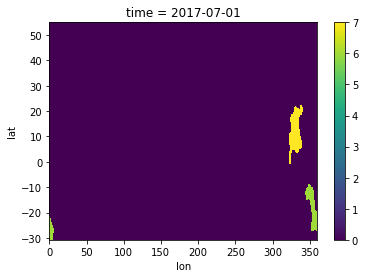

In [474]:
sub_labels_wrapped.isel(time=3).plot()

In [370]:
# unique labels
unique_labels = np.where(np.unique(sub_labels_wrapped)>0)[0]

# Loop through each unique object label
for ob in enumerate(unique_labels):
    print(ob)

(0, 1)
(1, 2)
(2, 3)
(3, 4)
(4, 5)
(5, 6)
(6, 7)
(7, 8)
(8, 9)


In [467]:
ob = (0,5)
ob

(0, 5)

In [557]:
x_dd.shape
density.shape

(2880,)

In [479]:
sub_object = np.where(sub_labels_wrapped==ob[1])
lat_centroid = sub_labels_wrapped.lat[sub_object[1]].mean()
lon_points = sub_labels_wrapped.lon[sub_object[2]]

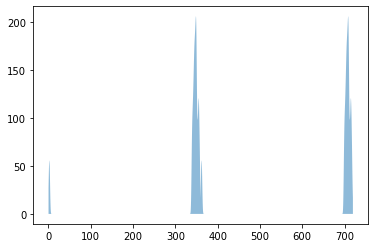

In [559]:
from scipy.stats import norm
x_d = sub_labels_wrapped.lon.values
x_dd = np.arange(sub_labels_wrapped.lon.values.min(), sub_labels_wrapped.lon.values.max()*2 + 2*sub_labels_wrapped.lon.values.min() ,.25)

x = lon_points.values
density = sum(norm(xi).pdf(x_d) for xi in x)
density = np.concatenate((density,density))

plt.fill_between(x_dd, density, alpha=0.5)


In [562]:
from scipy.signal import find_peaks
peaks, _ = find_peaks(density, height=0, distance=100)
peaks[1]

1394

In [563]:
centroid = x_dd[peaks[1]]

348.625

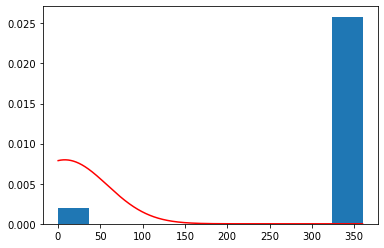

In [515]:
from scipy.stats import norm
fitted_data = norm.pdf(x_d, peaks[0], 50)
plt.hist(x, density=True)
plt.plot(x_d,fitted_data,'r-')

In [521]:
Ind = np.where(x_d>0)
Ind[0].shape

(1440,)

In [469]:
np.round(lon_points.max()-lon_points.min()) == 360 # if there is a split

<xarray.DataArray 'lon' ()>
array(True)

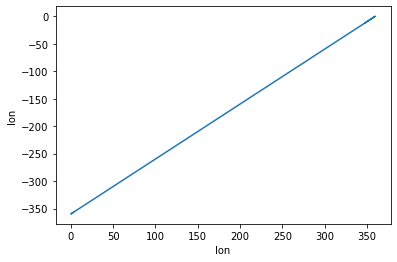

In [466]:
(lon_points-lon_max).plot()


In [ ]:
# def check_boundaries(poxsitions, unitCellLength):
  #Function to check if an atom has crossed a cell boundary, if so, translate it back into the cell

In [459]:
sub_labels_wrapped.lon.values.max()

359.875

In [453]:
lon_max = sub_labels_wrapped.lon.values.max()
for x in lon_points.values:
    if x.all()==lon_max:
        print('yes')

In [421]:
for x,y,z position in atom_coordinates
   if ( xyz_position > wall_max) 
      position = position - unit_cell_length
   if ( xyz_position < wall_min)
      position = position + unit_cell_length

<xarray.DataArray 'lon' ()>
array(359.875)

In [417]:
sub_labels_wrapped.lon[sub_object[2]]

<xarray.DataArray 'lon' (lon: 3001)>
array([347.875, 348.125, 348.375, ...,   2.375,   2.625,   2.875],
      dtype=float32)
Coordinates:
  * lon      (lon) float32 347.9 348.1 348.4 348.6 ... 2.125 2.375 2.625 2.875

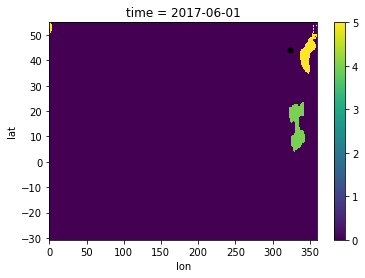

In [416]:
sub_labels_wrapped.isel(time=2).plot()
plt.plot(lon_centroid,lat_centroid,'.k',ms=10)

In [358]:
s=3
coords = sub_labels_wrapped.isel(time=s).stack(z=('lat','lon'))
# coord_pairs = [(coords.isel(time=t[0]).dropna(dim='z', how='any').z.lat.values, 
#                 coords.isel(time=t[0]).dropna(dim='z', how='any').z.lon.values) for t in enumerate(sub_labels_wrapped.time)]


In [359]:
coords

<xarray.DataArray (z: 493920)>
array([0, 0, 0, ..., 0, 0, 0])
Coordinates:
    time     datetime64[ns] 2017-07-01
  * z        (z) MultiIndex
  - lat      (z) float64 -30.62 -30.62 -30.62 -30.62 ... 54.88 54.88 54.88 54.88
  - lon      (z) float64 0.125 0.375 0.625 0.875 ... 359.1 359.4 359.6 359.9

In [344]:
s=3
coords = mhw['coords'][0][s]
centroid = [sum(le) / len(coords) for le in zip(*coords)]


In [345]:
coords

(array([-30.625, -30.625, -30.625, ...,  22.625,  22.625,  22.625]),
 array([  1.625,   1.875,   2.125, ..., 339.375, 339.625, 339.875]))

In [346]:
print(coords[0].mean()) # lat
print(coords[1].mean()) # lon

-1.360127985127985
304.3984162734163


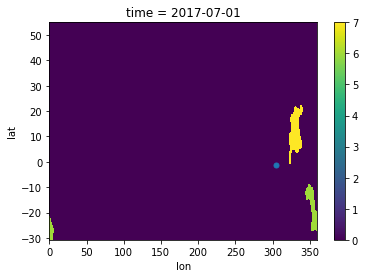

In [347]:
sub_labels_wrapped.isel(time=s).plot()
plt.plot(coords[1].mean(),coords[0].mean(),'.',ms=10)

In [343]:
def _get_centroids(sub_labels):
    '''This function uses skimage.measure.regionprops to find the centroids of objects assigned 
    to each unique label'''
    props = regionprops(sub_labels.astype('int'))
    centroids = [(float(sub_labels.lat[round(p.centroid[0])].values), 
                  float(sub_labels.lon[round(p.centroid[1])].values)) for p in props]
    return centroids

centroid = []
for s in np.arange(0, sub_labels_wrapped.shape[0]):
    centroid.append(_get_centroids(sub_labels_wrapped.isel(time=s)))
mhw['centroid'].append(centroid)

In [236]:
mhw = _get_intensity_area(event, ssta, mhw)
    
mhw = pd.DataFrame(dict([(name, pd.Series(data)) for name,data in mhw.items()]))

In [237]:
mhw

,id,date,coords,centroid,duration,intensity_max,intensity_mean,intensity_min,intensity_cumulative,area
0,699,"[2017-04, 2017-05, 2017-06, 2017-07, 2017-08, ...","[([-12.375, -12.375, -12.375, -12.375, -12.375...","[[(-1.625, 339.125), (32.375, 340.125)], [(21....",6,"[1.4137356802751988, 1.7401016215227756, 2.280...","[0.6898729359307344, 0.9257639070557462, 1.040...","[0.286687032601165, 0.2749378956431556, 0.3704...",19420.592193,"[5542730.708388358, 6639489.804851622, 4714945..."


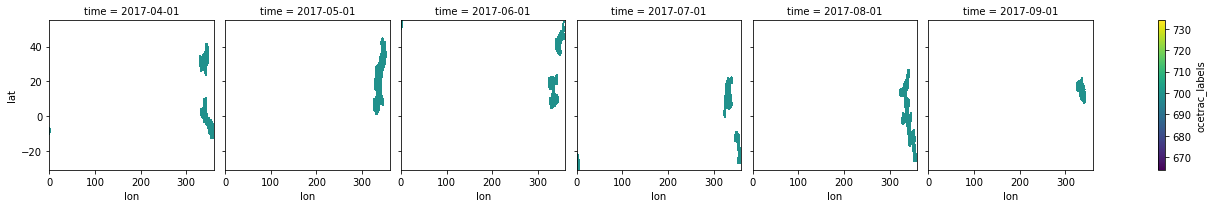

In [238]:
event.plot(col='time', col_wrap=event.shape[0], robust=True);

In [ ]:
%%time
mhw = create_dataset(event, ssta)
mhw

In [239]:
import sys
print(f'size of mhw is {sys.getsizeof(mhw)/1e6 *700} mb')

size of mhw is 0.8008000000000001 mb


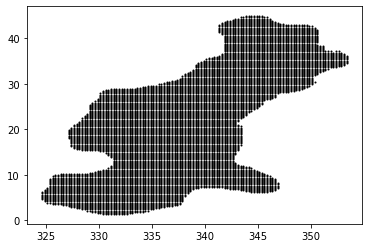

In [240]:
y, x = zip(*mhw['coords'][0])
plt.scatter(x[1], y[1], s=1, c='k')

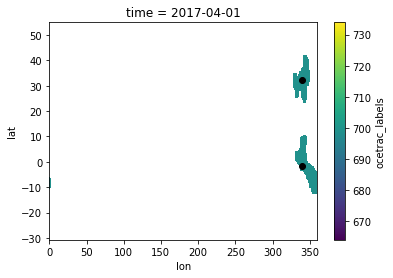

mean intensity (ºC) 0.69
max intensity (ºC) 1.41
min intensity (ºC) 0.29
area (km2) 5542730.71


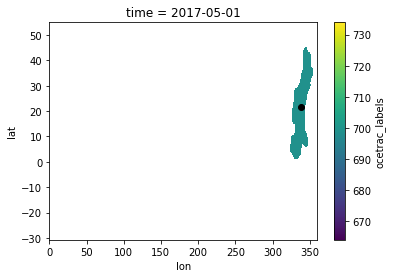

mean intensity (ºC) 0.93
max intensity (ºC) 1.74
min intensity (ºC) 0.27
area (km2) 6639489.8


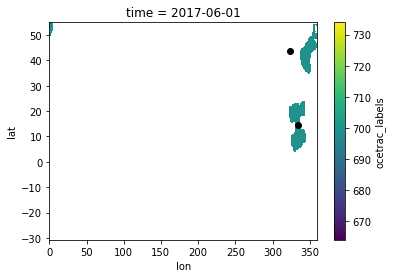

mean intensity (ºC) 1.04
max intensity (ºC) 2.28
min intensity (ºC) 0.37
area (km2) 4714945.03


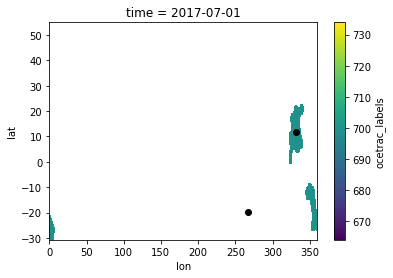

mean intensity (ºC) 0.63
max intensity (ºC) 1.11
min intensity (ºC) 0.29
area (km2) 5161560.32


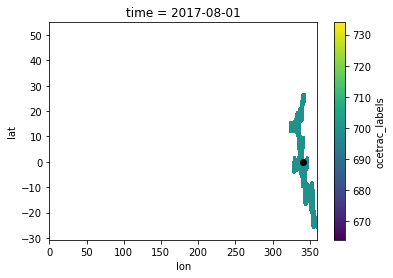

mean intensity (ºC) 0.67
max intensity (ºC) 1.58
min intensity (ºC) 0.07
area (km2) 6726704.24


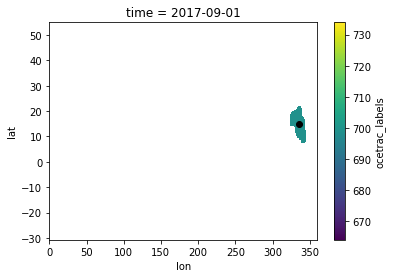

mean intensity (ºC) 0.6
max intensity (ºC) 1.16
min intensity (ºC) 0.12
area (km2) 2047628.58


In [241]:
for c in np.arange(0,mhw['duration'][0]):
    plt.figure()
    y, x = zip(*mhw['centroid'][0][c])
    event[c,:,:].plot()
    plt.scatter(x, y, c='k')
    plt.show()
    print('mean intensity (ºC)', round(mhw['intensity_mean'][0][c],2))
    print('max intensity (ºC)', round(mhw['intensity_max'][0][c],2))
    print('min intensity (ºC)', round(mhw['intensity_min'][0][c],2))
    print('area (km2)', round(mhw['area'][0][c],2))

#### To CSV

In [ ]:
path = '/burg/abernathey/users/hillary/oisst_v21/test.csv'
mhw.to_csv(path, index=False)

#### Read CSV to Pandas DataFrame

In [ ]:
df = pd.read_csv(path)
df